# Example: Cross-contour transport

This notebook uses the `cosima_cookbook` to calculate transport across an arbitrary contour. We do this by first creating the contour, such as sea surface height, and extracting the coordinates using `matplotlib`'s `Path` class. We then create some masks to indicate which direction is across the contour at each position along the contour. We then load the transport data and compute the transport, resulting in data with dimensions depth and along contour index. 

Computation times shown used conda environment `analysis3-22.07` on the large compute size on NCI's ARE.

First, we load useful packages:

In [6]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import logging
import os
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

from dask.distributed import Client
client = Client(n_workers=28)

#### Choose database

In [7]:
session = cc.database.create_session()

In [8]:
experiment = '01deg_jra55v13_ryf9091'

In [9]:
lat_range = slice(-79, -56)

We do not have the daily heat transports for the ryf. Id have to calculate them offline (based on the mass transports.  So check which years we have daily mass transports

In [160]:
vars0 = cc.querying.get_variables(session, experiment='01deg_jra55v13_ryf9091')
vars0[vars0['name'].str.lower().str.contains('int')]

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
124,frazil_3d_int_z,Vertical sum of ocn frazil heat flux over time...,W/m^2,1 daily,output1115/ocean/ocean_daily.nc,time: mean,942,1956-04-01 00:00:00,2180-01-01 00:00:00
197,frazil_3d_int_z,Vertical sum of ocn frazil heat flux over time...,W/m^2,1 monthly,output1115/ocean/ocean_month.nc,time: mean,1164,1900-01-01 00:00:00,2180-01-01 00:00:00
314,tx_trans_int_z,T-cell i-mass transport vertically summed,kg/s,1 monthly,output1115/ocean/ocean_month.nc,time: mean,1164,1900-01-01 00:00:00,2180-01-01 00:00:00
318,ty_trans_int_z,T-cell j-mass transport vertically summed,kg/s,1 monthly,output1115/ocean/ocean_month.nc,time: mean,1164,1900-01-01 00:00:00,2180-01-01 00:00:00


In [110]:
lat_range

slice(-79, -56, None)

In [156]:
u_daily = cc.querying.getvar(experiment, 'u', session,frequency='3 hourly',start_time='2141-01',end_time='2141-02')
v_daily = cc.querying.getvar(experiment, 'v', session,frequency='3 hourly',start_time='2141-01',end_time='2141-02')
u_daily = u_daily.sel(time=(u_daily['time.month'] == 1))
v_daily = v_daily.sel(time=(v_daily['time.month'] == 1))

Ty_daily = cc.querying.getvar(experiment, 'temp_yflux_adv', session,frequency='3 hourly',start_time='2141-01',end_time='2141-02')
Ty_daily = Ty_daily.sel(time=(Ty_daily['time.month'] == 1))


#Ty_daily = Ty_daily.sel(time=(Ty_daily['time.month'] == 1)).groupby('time.day').mean(dim='time')
Tx_daily = cc.querying.getvar(experiment, 'temp_xflux_adv', session,frequency='3 hourly',start_time='2141-01',end_time='2141-02')
Tx_daily = Tx_daily.sel(time=(Tx_daily['time.month'] == 1))
#Tx_daily = Tx_daily.sel(time=(Tx_daily['time.month'] == 1)).groupby('time.day').mean(dim='time')
    #after TX daily here I will likely need toa ttribute new and corect timestamps. 
    #I might be able to copy the ones from u,v into them
vhrho_daily = cc.querying.getvar(experiment, 'vhrho_nt', session,frequency='1 daily',n=-50)
#vhrho_daily = vhrho_daily.sel(time=(vhrho_daily['time.month'] == 1))
#vhrho_daily = vhrho_daily.sel(time=(vhrho_daily['time.month'] == 1)).groupby('time.day').mean(dim='time')


# uhrho_daily = cc.querying.getvar(experiment, 'uhrho_et', session,frequency='1 daily',start_time='2141-01',end_time='2141-02')
# uhrho_daily = uhrho_daily.sel(time=(uhrho_daily['time.month'] == 1))
vhrho_years=vhrho_daily.groupby('time.year').mean(dim='time').year
vhrho_years=vhrho_daily.groupby('time.year').mean(dim='time').year
# we dont have vhrho daily for year 2141

<xarray.DataArray 'year' (year: 11)>
array([2100, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179])
Coordinates:
  * year     (year) int64 2100 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179

I have just realized that this u,v 3 hourly data are in a small spatial location, so they do not work for the calculations we want

In [136]:
	import xgcm
	lat_slice = slice(-80, -59)
	hu = cc.querying.getvar(experiment, 'hu', session, n=1)
	path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
	grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

	ds = xr.merge([hu, grid])
	ds.coords['xt_ocean'].attrs.update(axis='X')
	ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	ds.coords['yt_ocean'].attrs.update(axis='Y')
	ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	
	grid = xgcm.Grid(ds, periodic=['X'])
	
	# Take gradient and move to u grid
	# Simple gradient over one grid cell. 
	# In latitudinal direction, we need to specify what happens at the boundary.
	dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
	dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')
	
	# Same as: (other option)
	#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
	#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu
	
	# Select latitude slice
	dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
	dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)
	
	# Calculate the magnitude of the topographic slope
	slope = (dhu_dx**2 + dhu_dy**2)**0.5 #before it was : xu.sqrt(dhu_dx**2 + dhu_dy**2)
	

In [139]:
		u_along = u_daily*dhu_dy/slope - v_daily*dhu_dx/slope
		# Cross-slope velocity
		v_cross = u_daily*dhu_dx/slope + v_daily*dhu_dy/slope

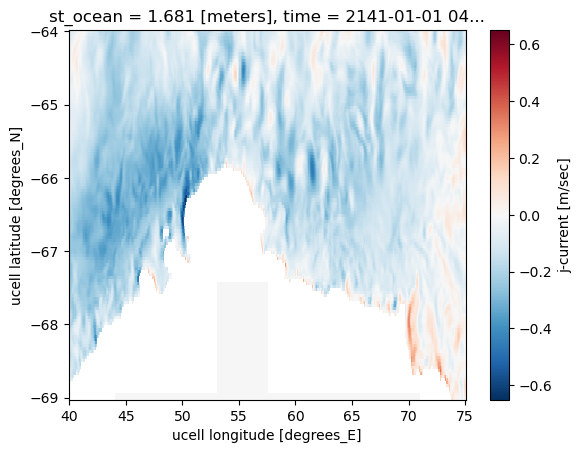

In [143]:
v_daily.isel(st_ocean=1,time=1).plot()

In [89]:
#Seems to me we have U and v daily for the whole period. 
#Lets see now the vars for the heat transport, which are:
#temp_yflux_adv: We have hourly and will have to average to daily. period= only year 2141 
#temp_xflux_adv: We have hourly and will have to average to daily. period= only year 2141 
    #SO you will have to import every month separate, then average per day. 
    #cannot import more than one month at a time. Also notice that importing by
    #start and end date in this 3-hourly output doesnt really work well, so you will have 
    #to cut them properly after importing. ABove there is N EXAMPLE ON HOW TO DO THAT FOR TX_TRANS
#vhrho_nt
#uhrho_et


#UPDATE, IT SEEMS TAHT AT YEAR 2141 WE HAVE 3HOURLY DATA FOR EVERYTHING. SO LETS TRY TO CALCULATE IT 3-HOURLY

    

In [42]:
%%time

yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean = lat_range)

xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean = lat_range)

xu_ocean = cc.querying.getvar(experiment, 'xu_ocean', session, n=1)

CPU times: user 15.9 s, sys: 4.38 s, total: 20.3 s
Wall time: 26.8 s


In [7]:
if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean')> yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean')> xu_ocean.min('xu_ocean'):
    print('help! x wrong order')

In [8]:
start_time = '2170-01-01'
end_time = '2170-12-31'
time_slice = slice(start_time, end_time)
bath = cc.querying.getvar(experiment,'ht', session, n=-1)

# select one year and latitude range
bath_mean = bath.sel(yt_ocean = lat_range)



#### Choose your desired contour value

In [9]:
contour_depth = 1000

In [10]:
# fig = plt.figure(figsize = (10, 4))

# bath_mean.plot(extend='both', cbar_kwargs={'label': "Ocean Depth [m]"})
# bath_mean.plot.contour(levels = [contour_depth], colors = 'k', linestyles = '-')
# plt.title('Bathymetry (m)');

In [11]:
h = bath_mean.load()

# Fill in land with zeros:
h = h.fillna(0)

In [12]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

In [13]:
if grid_sel == 'u':
    x_var = xu_ocean
    y_var = yu_ocean
elif grid_sel == 't':
    x_var = xt_ocean
    y_var = yt_ocean

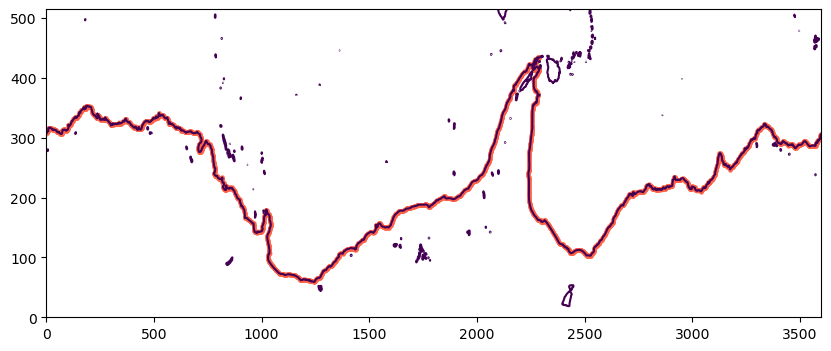

In [14]:
fig = plt.figure(figsize = (10, 4))
count = 1
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        if count ==  2:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [15]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [16]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [17]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

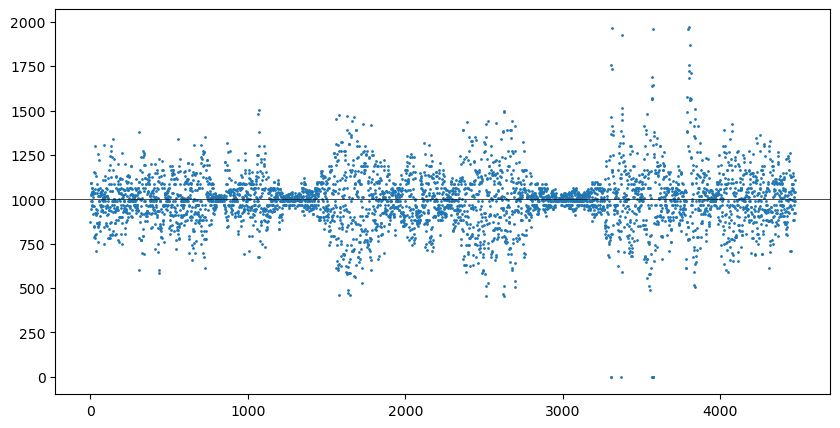

In [18]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

#### Get lat and lon along the contour

In [19]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]

In [20]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [21]:
np.shape(lat_along_contour)

(4476,)

In [22]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

#### Now we number the points along the contour

In [23]:
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

In [24]:
contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

In [25]:
# plt.figure(1, figsize=(16, 8))
# contour_mask.plot(extend='both');

In [26]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

In [27]:
# plt.figure(1, figsize=(16, 8))

# plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, contour_masked_above)
# plt.colorbar();

South of the contour, values have been filled in to be -100, and it is thus a different colour in the plot.

#### Direction of cross-contour transport
Now we can use the mask south of the contour to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (above contour) and -100 (below contour). This means the orientation of the contour can be determined. This is saved as `mask_x_transport`, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and `mask_y_transport` which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport `ty_trans` by the `mask_y_transport` gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).

In [28]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

In [29]:
# plt.figure(1, figsize=(16, 8))

# plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_x_transport)
# plt.colorbar();

As can be seen, in `mask_x_transport` there is yellow (+1) where eastward transport crosses the contour, and (-1) where westward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport. 

We now proceed to calculate transports across the contour

In [30]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims = ['y_ocean','x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims = ['y_ocean','x_ocean'])

And plot just to confirm that we didn't mess up anything.

In [31]:
# plt.figure(1, figsize=(16, 8))

# mask_x_transport.plot(cmap="viridis");

In [32]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

#### Stack contour data into 1D

#### Load transports `tx_trans` and `ty_trans`

In [33]:
#ty_trans = cc.querying.getvar(experiment, 'ty_trans', session, start_time = start_time, end_time = end_time)
ni=-20 #Number of netcdfs to import
ty_trans2 = cc.querying.getvar(experiment, 'temp_yflux_adv', session, frequency = '1 monthly',n=ni)
#ty_trans = ty_trans.sel(yu_ocean = lat_range).groupby('time.year').mean(dim='time')
#ty_trans = ty_trans.rename({'year': 'time'})

#tx_trans = cc.querying.getvar(experiment, 'tx_trans', session, start_time = start_time, end_time = end_time)

tx_trans2 = cc.querying.getvar(experiment, 'temp_xflux_adv', session, frequency = '1 monthly',n=ni)
#tx_trans = tx_trans.sel(yt_ocean = lat_range).groupby('time.year').mean(dim='time')
#tx_trans = tx_trans.rename({'year': 'time'})

ty_trans2 = ty_trans2.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
tx_trans2 = tx_trans2.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})

#### Take time average

#### Extract transport values along contour

In [34]:
# CELL IN CONSTRUCTION! YOU WILL NEED TO RERUN TEH CODE AFTER THAT
ni=-20 #Number of netcdfs to import
cp = 3992.1# kg/m^3
# WE NEED TO DISCOUNT THE HEAT TRANSPORT FOR THE TREF=3.82 CELSIUS. IN TORDER TO DO THAT WE WILL

# [A] IMPORT THE MASS TRANSPORT
ty_trans = cc.querying.getvar(experiment, 'ty_trans', session, frequency = '1 monthly',n=ni)
tx_trans = cc.querying.getvar(experiment, 'tx_trans', session, frequency = '1 monthly',n=ni)

# [B] CONVERT THE MASS TRANSPORT INTO HEAT TRANSPORT, BUT CONSIDERING ALL CELLS TO HAVE TREF=-3.82

ty_trans=ty_trans*cp*(-3.82)
tx_trans=tx_trans*cp*(-3.82)


ty_trans = ty_trans.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
tx_trans = tx_trans.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})

# [C]DISCOUNT THIS REFERENCE HEAT TRANSPORT FROM TY_TRANS AND TX_TRANS

tx_transp=tx_trans2-tx_trans
ty_transp=ty_trans2-ty_trans

In [35]:
%%time
#import logging
#logging.captureWarnings(True)
#logging.getLogger('py.warnings').setLevel(logging.ERROR)
#logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)
## We could also loop in time if we didn't want the time average. 

# stack transports into 1d and drop any points not on contour:
x_transport_1d = tx_transp.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = ty_transp.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

CPU times: user 22.9 s, sys: 3.75 s, total: 26.6 s
Wall time: 23.2 s


In [ ]:
%%time
# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()


In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))

vol_trans_across_contour.cumsum('contour_index').isel(time=-1).plot()
ax.set_ylabel('Cumulative transport across contour');

2023-04-27 16:33:36,753 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.03 GiB -- Worker memory limit: 17.89 GiB
2023-04-27 16:33:56,601 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-04-27 16:33:56,611 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.41 GiB -- Worker memory limit: 17.89 GiB


#### Finally, we can extract the coordinates of the contour index, and the distance, for a more meaningful $x$ axis.

In [154]:
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [135]:
# %%time
# # for some reason dxu and dyt for the RYF experiment is getting errors in selecting the latitude range. (different coord names and indexes)
# #Since the grid is the same Imma use the dxy and dyt from the IAF experiment
# dxu = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'dxu', session, n=1)
# dxu = dxu.sel(yu_ocean = lat_range)

# dyt = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'dyt', session, n=1)
# dyt = dyt.sel(yt_ocean = lat_range)

# num_points = len(lat_along_contour)


In [138]:
# #Calculating the distance wuisng geopy
# import geopy.distance
# distance_along_contour = []

# for count in range(0, num_points):
#     if count in range(1, num_points-1):
#         coords_1 = (lat_along_contour[count],lon_along_contour[count])
#         coords_2 = (lat_along_contour[count+1],lon_along_contour[count+1])
#         a =  geopy.distance.geodesic(coords_1, coords_2).km
#         distance_along_contour.append(a)
#     else:
#         coords_1 = (lat_along_contour[num_points-1],lon_along_contour[num_points-1])
#         coords_2 = (lat_along_contour[0],lon_along_contour[0])
#         a =  geopy.distance.geodesic(coords_1, coords_2).km
#         distance_along_contour.append(a)    

# distance_along_contour = np.cumsum(distance_along_contour) / 1e3 
# #distance_along_contour = np.array(distance_along_contour) / 1e3 
# np.shape(distance_along_contour)


(5998,)

In [149]:
distance_along_contour

array([4.53152744e-03, 7.80146865e-03, 1.23405076e-02, ...,
       2.50418252e+01, 2.50450926e+01, 2.50496241e+01])

In [156]:
# NOTE: This cell takes about 10 minutes to run
# if there is a bend in the contour, add the distance using the half-length of the diagonal
# instead of the sum of 2 edges, to be more representative.
distance_along_contour = np.zeros((num_points))

x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])

skip = False
# note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# which for this latitude range there is not. If using a different latitude range, choose an x value that is
# not a nan/land for the entire latitude range
dxu = dxu.isel(xu_ocean = 0)
dyt = dyt.isel(xt_ocean = 0)

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do not vary in x:
            jj = np.where(mask_y_transport_numbered==count)[0]
            distance_along_contour[count-1] = (dxu[jj])[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)[0]
            half_diagonal_distance = 0.5 * np.sqrt((dxu[jj0])[0]**2 + (dyt[jj1])[0]**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)[0]
            distance_along_contour[count-1] = (dyt[jj])[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)[0]
            half_diagonal_distance = 0.5 * np.sqrt((dyt[jj0])[0]**2 + (dxu[jj1])[0]**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)[0]
        distance_along_contour[-1] = (dxu[jj])[0]
    else:
        jj = np.where(mask_x_transport_numbered==count)[0]
        distance_along_contour[-1] = (dyt[jj])[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3

#### Select the indices for axis labels of specific longitudes, so we can plot transport vs distance but have longitude labels instead of length

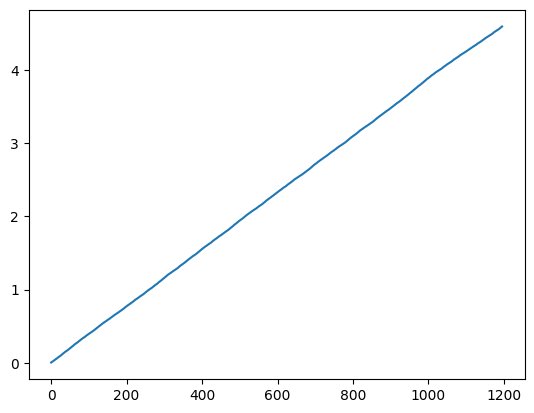

In [160]:
plt.plot(distance_along_contour)

In [159]:
distance_indices = np.zeros(8)

for i in np.arange(100, len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]

distance_indices[7] = len(lon_along_contour.contour_index.values)-1

#### Plot cumulative transport against distance along the contour.

In [152]:
#depth_to_integrate = 500 # m
#WE DO NOT NEED TO INTEGRATE
vol_trans_across_contour

<xarray.DataArray (time: 60, st_ocean: 75, contour_index: 5998)>
array([[[-3.4068385e+09, -4.4571996e+09, -3.6812616e+09, ...,
         -3.5236695e+09, -6.0302612e+09, -3.9353188e+09],
        [-4.1353620e+09, -4.0485752e+09, -4.4300247e+09, ...,
         -4.2674120e+09, -5.7243264e+09, -4.7228452e+09],
        [-4.7860557e+09, -3.8325120e+09, -5.1046431e+09, ...,
         -4.9209400e+09, -5.6488965e+09, -5.4234906e+09],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-2.6235220e+09, -2.5011277e+09, -2.8403497e+09, ...,
         -2.6895452e+09, -3.2459615e+09, -2.5202918e+09],
        [-2.9760722e+09, -2.0290220e+09, -3.2118275e+09, ...,
         -3.0337695e+09, -2.8356813e+09, -2.8568965e+09],
        [-3.2750226e+09, -1.7668826e+09, -3.5256929e+09, ...,
         -3.3301796e+09, -2.6486205e+09, -3.1450568e+09],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.3413064e+09, -6.7651313e+09, -4.7829750e+09, ...,
         -4.2718687e+09, -6.6984248e+09, -4.3523154e+09],
        [-4.7794514e+09, -6.6018806e+09, -5.2868260e+09, ...,
         -4.6991380e+09, -6.5158676e+09, -4.7895798e+09],
        [-5.2713820e+09, -6.6749399e+09, -5.8470810e+09, ...,
         -5.1854152e+09, -6.5690629e+09, -5.2818458e+09],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * st_ocean       (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time           (time) object 2175-01-16 12:00:00 ... 2179-12-16 12:00:00
  * contour_index  (contour_index) int64 1 2 3 4 5 ... 5994 5995 5996 5997 5998

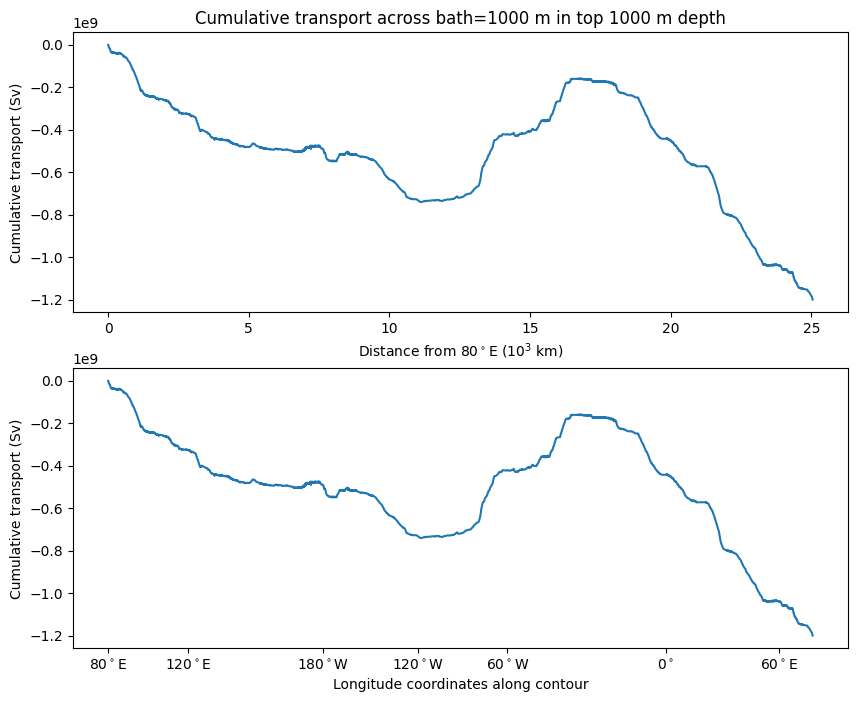

In [153]:
#Doing it for the first year just to avoid HDF5 error
depth_to_integrate=1000;
fig, axes = plt.subplots(nrows = 2, figsize = (10, 8))

#axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(st_ocean = slice(0, depth_to_integrate)).mean(dim='time').sum('st_ocean').cumsum('contour_index')))
axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.isel(time=slice(0,12,1)).mean(dim='time').sum(dim='st_ocean').cumsum('contour_index')))


axes[0].set_ylabel('Cumulative transport (Sv)')
axes[0].set_xlabel('Distance from 80$^\circ$E (10$^3$ km)')
#axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative transport across bath={contour_depth} m in top {depth_to_integrate} m depth')

#axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(st_ocean = slice(0, depth_to_integrate)).mean(dim='time').sum('st_ocean').cumsum('contour_index')))
axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.isel(time=slice(0,12,1)).mean(dim='time').sum(dim='st_ocean').cumsum('contour_index')))


axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
#axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Cumulative transport (Sv)');

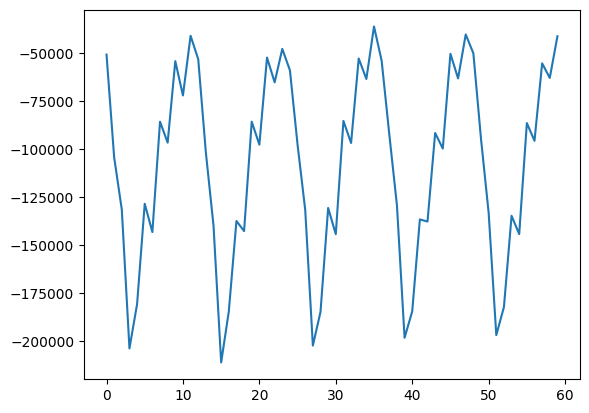

In [55]:
#THe full zonal transport distribution for Totten ice shelf
depth_to_integrate=1000 #m
Full_trans=(1e-6 * vol_trans_across_contour.sel(st_ocean = slice(0, depth_to_integrate)).cumsum('contour_index'))

#selecting the points that I specifically am interested
TISLonmask=np.array(lon_along_contour)
TISLonmask[(TISLonmask<-245) | (TISLonmask>-235)] = 0
TISLonmask[(TISLonmask>-245) & (TISLonmask<-235)] = 1



TIStrans= np.multiply((1e-6 * vol_trans_across_contour.mean(dim='time').cumsum('contour_index')),TISLonmask)
TIS_t=np.empty(0)
for i in range(60):
    a= np.mean(np.multiply((1e-6 * vol_trans_across_contour.isel(time=i).cumsum('contour_index')),TISLonmask))
    TIS_t=np.append(TIS_t,a)

plt.plot(TIS_t)

In [59]:
TIS_t

array([ -50851.28214375, -104315.10302483, -131493.19501785,
       -203693.72943759, -180636.09915447, -128441.4347505 ,
       -143153.03939167,  -85764.64762148,  -96660.19766004,
        -54276.6527828 ,  -72111.22941349,  -41077.83147855,
        -53260.89799542, -101815.17843778, -139822.04446322,
       -210992.62554289, -184504.16134563, -137403.64967619,
       -142648.77538338,  -85758.80781239,  -97698.3791936 ,
        -52403.43191317,  -65286.0343343 ,  -47893.65456725,
        -59060.08110882,  -97806.95204285, -131651.26873677,
       -202193.34334431, -184707.4762903 , -130626.6937942 ,
       -144283.66155012,  -85364.63257014,  -96837.32238182,
        -52901.38344984,  -63528.24024484,  -36235.75905244,
        -54061.49157583,  -92313.32624969, -129207.69225492,
       -198169.35690897, -184418.95010436, -136603.40823975,
       -137683.07828501,  -91624.78949755,  -99725.3447364 ,
        -50453.42512671,  -63240.66666801,  -40389.24333203,
        -50165.25281088,

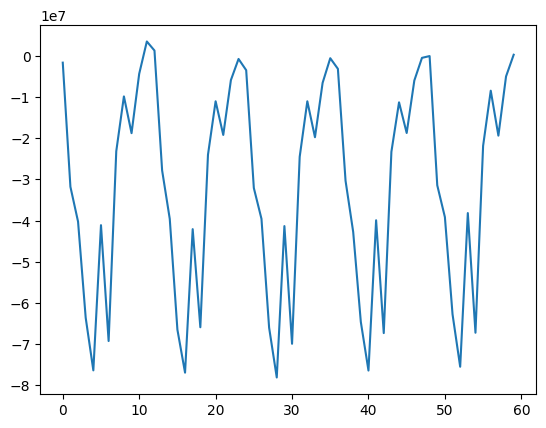

In [60]:
#THe full zonal transport distribution for Amery ice shelf {'xu_ocean': slice(68, 80)}
#Full_trans=(1e-6 * vol_trans_across_contour.sel(st_ocean = slice(0, depth_to_integrate)).cumsum('contour_index'))

#selecting the points that I specifically am interested
AISLonmask=np.array(lon_along_contour)
AISLonmask[(AISLonmask<68) | (AISLonmask>80)] = 0
AISLonmask[(AISLonmask>80) & (AISLonmask<68)] = 1



#AIStrans= np.multiply((1e-6 * vol_trans_across_contour.mean(dim='time').cumsum('contour_index')),AISLonmask)
AIS_t=np.empty(0)
#print(np.arange(0,12,1))
for i in range(60):
    a= np.mean(np.multiply((1e-6 * vol_trans_across_contour.isel(time=i).cumsum('contour_index')),AISLonmask))
    AIS_t=np.append(AIS_t,a)

plt.plot(AIS_t)

In [61]:
AIS_t

array([-1.66013687e+06, -3.17986163e+07, -4.02635647e+07, -6.36077266e+07,
       -7.63818972e+07, -4.11229551e+07, -6.92566085e+07, -2.31710633e+07,
       -9.85396147e+06, -1.87806994e+07, -4.37429121e+06,  3.47993517e+06,
        1.27827039e+06, -2.78238359e+07, -3.96077562e+07, -6.64927364e+07,
       -7.69344579e+07, -4.20875810e+07, -6.59106190e+07, -2.40223426e+07,
       -1.10387598e+07, -1.92171597e+07, -5.89242114e+06, -7.61767439e+05,
       -3.49326886e+06, -3.20956604e+07, -3.95843964e+07, -6.60129017e+07,
       -7.81068330e+07, -4.13447902e+07, -6.99272609e+07, -2.45298040e+07,
       -1.10375769e+07, -1.97708952e+07, -6.56781909e+06, -5.84325088e+05,
       -3.16255299e+06, -3.03279419e+07, -4.27571763e+07, -6.46192552e+07,
       -7.64239641e+07, -3.99320472e+07, -6.73315032e+07, -2.33071275e+07,
       -1.12935508e+07, -1.87431244e+07, -6.00099113e+06, -4.97535998e+05,
       -6.00064628e+04, -3.14298153e+07, -3.91641849e+07, -6.27644116e+07,
       -7.54987100e+07, -

In [ ]:
vol_trans_across_contour